In [4]:
from copy import copy
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE

In [5]:
N = 30
q = 1
T = 5000
b = 80
D = np.sqrt(b)
L = b
G = np.sqrt(b**3)
np.random.seed(0)

alphas = [80/np.sqrt(np.sum([((4*np.pi**2)**k)*((j/2)**(2*k)) for k in range(3)])) for j in range(2*N + 1)]
alphas_4 = [4*alphas[j] for j in range(len(alphas))]
D_2m = sum(alphas_4)

In [6]:
def join_arrs(a0, arr1, arr2):
    new_arr = np.zeros(len(arr1) + len(arr2))
    new_arr[::2] = arr1
    new_arr[1::2] = arr2
    new_arr = np.concatenate(([a0], new_arr))
    return new_arr

def solve_euler(h, q):
    t = symbols('t')
    x = Function('x')
    C1 = symbols('C1')
    C2 = symbols('C2')
    x = dsolve(- diff(x(t), t, t) + q**2*x(t) - h , x(t)).rhs
    cond1 = x.subs(t, 0) - x.subs(t, 1)
    cond2 = diff(x, t).subs(t, 0) - diff(x, t).subs(t, 1)
    solution = solve([cond1, cond2], [C1, C2])
    x = x.subs(C1, solution[C1]).subs(C2, solution[C2])
    return x

def pop_fourier_coefs(func):
    a0 =  np.trapezoid(func(np.linspace(0, 1, 100)), np.linspace(0, 1, 100))
    an = np.zeros(N)
    bn = np.zeros(N)

    for n in range(1, N+1):
        an[n-1] =  np.trapezoid(func(np.linspace(0, 1, 100)) * np.sqrt(2)*np.cos(n * 2*np.pi * np.linspace(0, 1, 100)), np.linspace(0, 1, 100))
        bn[n-1] =  np.trapezoid(func(np.linspace(0, 1, 100)) * np.sqrt(2)*np.sin(n * 2*np.pi * np.linspace(0, 1, 100)), np.linspace(0, 1, 100))

    return a0, an, bn

def fourier_series(t, a0, an, bn, N):
    return a0 + np.sum([an[n] * np.sqrt(2)*np.cos((n+1) * 2*np.pi * t) + bn[n] * np.sqrt(2)*np.sin((n+1) * 2*np.pi * t) for n in range(N)])


## $\psi$ = 1.5

In [ ]:
# Initialize arrays
w = np.zeros((T, 2*N+1))
w_wave = np.zeros((T, 2*N+1))
w[0] = np.random.random(2*N+1)
w_wave[0] = np.random.random(2*N+1)

# Symbolic setup
t = symbols('t')
h_sp = 10*pi**2*cos(2*1.5*pi*t)
h = lambdify(t, h_sp, 'numpy')

# Solve system and get Fourier coefficients
x_sp = solve_euler(h_sp, q)
x = lambdify(t, x_sp, 'numpy')
a0, an, bn = pop_fourier_coefs(x)
h_a0, h_an, h_bn = pop_fourier_coefs(h)
x_hat = join_arrs(a0, an, bn)
h_hat = join_arrs(h_a0, h_an, h_bn)

# Precompute terms
sqrt_alphas = np.sqrt(alphas)
freq_terms = q**2 + (2*np.pi)**2 * ((np.arange(2*N+1) // 2)**2
alpha_freq = alphas * freq_terms

# Define gradient and objective
def gradient(w):
    return alpha_freq * w - sqrt_alphas * h_hat

def J_n(w):
    return 0.5 * np.sum(alpha_freq * w**2) - np.sum(sqrt_alphas * h_hat * w)

# Initialize variables
eta = np.zeros(T)
eta[0] = D / np.sqrt(10*D**2*L**2 + 4*G**2)
gradient_history = np.zeros((T, 2*N+1))
dif_grads_norm = []
J_opt = J_n(x_hat / sqrt_alphas)
Regret_J_n, Regret_J_n_sqrt = [], []
Dif_J_n = []

# Main loop
for i in range(T-1):
    gradient_history[i+1] = gradient(w[i])

    grad_diff = gradient_history[i+1] - gradient_history[i]
    dif_grads_norm.append(np.dot(grad_diff, grad_diff))
    eta[i+1] = D / np.sqrt(10*D**2*L**2 + 4*G**2 + np.sum(dif_grads_norm))

    w_wave[i+1] = w_wave[i] - eta[i] * gradient_history[i]
    w[i+1] = w_wave[i+1] - eta[i+1] * gradient_history[i]

    current_diff = J_n(w[i]) - J_opt
    Dif_J_n.append(current_diff)
    n = len(Dif_J_n)
    Regret_J_n_sqrt.append(np.sum(Dif_J_n) / np.sqrt(n))
    Regret_J_n.append(np.sum(Dif_J_n) / n)

In [ ]:
Regret_J_n[-1]

4.79821742836616

In [ ]:
np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))

np.float64(7.578343545233679e-05)

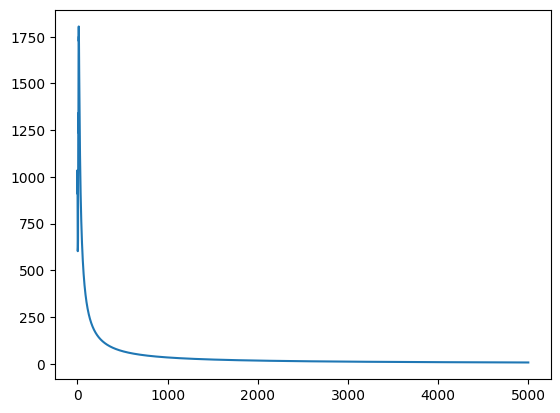

In [ ]:
plt.plot(Regret_J_n)

## $\psi$ = np.random.normal(0, 0.03, T)

In [ ]:
# Precompute constants
sqrt_alphas = np.sqrt(alphas)
freq_terms = q**2 + (2*np.pi)**2 * np.ceil(np.arange(2*N+1)/2)**2
alpha_freq = alphas * freq_terms

# Initialize arrays
w = np.zeros((T, 2*N+1))
w_wave = np.zeros((T, 2*N+1))
w[0] = np.random.random(2*N+1)
w_wave[0] = np.random.random(2*N+1)

# Tracking variables
Regret_J_n, Regret_J_n_sqrt = [], []
Dif_J_n = []
grads = []
psi = np.random.normal(0, 0.03, T)

# Learning rate setup
eta = np.zeros(T)
eta[0] = D/np.sqrt(10*D**2*L**2 + 4*G**2)
gradient_w = np.zeros((T, 2*N+1))
dif_grads_norm = []

t = symbols('t')  # Time symbol

for i in range(T-1):
    # System dynamics
    h_sp = 10*pi**2*cos(2*psi[i]*pi*t)
    h = lambdify(t, h_sp, 'numpy')
    x_sp = solve_euler(h_sp, q)
    x = lambdify(t, x_sp, 'numpy')

    # Fourier coefficients
    a0, an, bn = pop_fourier_coefs(x)
    h_a0, h_an, h_bn = pop_fourier_coefs(h)
    x_hat = join_arrs(a0, an, bn)
    h_hat = join_arrs(h_a0, h_an, h_bn)

    # Gradient and objective
    gradient_w[i+1] = alpha_freq * w[i] - sqrt_alphas * h_hat
    J_n_current = 0.5*np.sum(alpha_freq * w[i]**2) - np.sum(sqrt_alphas * h_hat * w[i])

    # Update learning rate
    grad_diff = gradient_w[i+1] - gradient_w[i]
    dif_grads_norm.append(np.dot(grad_diff, grad_diff))
    eta[i+1] = D/np.sqrt(10*D**2*L**2 + 4*G**2 + np.sum(dif_grads_norm))

    # Weight updates
    w_wave[i+1] = w_wave[i] - eta[i]*gradient_w[i]
    w[i+1] = w_wave[i+1] - eta[i+1]*gradient_w[i]

    # Regret calculation
    current_diff = J_n_current - (0.5*np.sum(alpha_freq * (x_hat/sqrt_alphas)**2) - np.sum(sqrt_alphas * h_hat * (x_hat/sqrt_alphas)))
    Dif_J_n.append(current_diff)
    n = len(Dif_J_n)
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(n))
    Regret_J_n.append(np.sum(Dif_J_n)/n)

In [ ]:
np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))

np.float64(0.00222079664854391)

In [ ]:
Regret_J_n[-1]

np.float64(8.587106883236958)

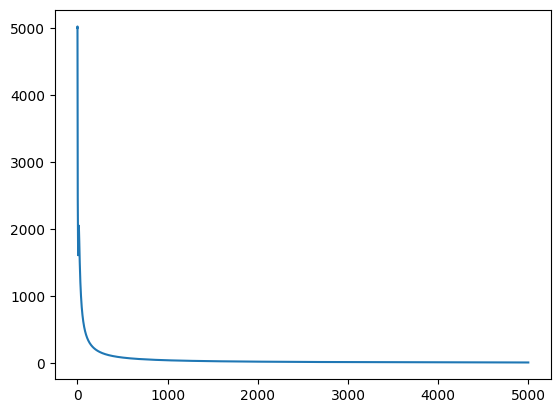

In [ ]:
plt.plot(Regret_J_n)

## $\psi$ = np.linspace(2, 3, T)

In [ ]:
# Precompute constants
sqrt_alphas = np.sqrt(alphas)
freq_terms = q**2 + (2*np.pi)**2 * np.ceil(np.arange(2*N+1)/2)**2
alpha_freq = alphas * freq_terms

# Initialize arrays
w = np.zeros((T, 2*N+1))
w_wave = np.zeros((T, 2*N+1))
w[0] = np.random.random(2*N+1)
w_wave[0] = np.random.random(2*N+1)

# Tracking variables
Regret_J_n, Regret_J_n_sqrt = [], []
Dif_J_n = []
grads = []
psi = np.linspace(2, 3, T)

# Learning rate setup
eta = np.zeros(T)
eta[0] = D/np.sqrt(10*D**2*L**2 + 4*G**2)
gradient_w = np.zeros((T, 2*N+1))
dif_grads_norm = []

t = symbols('t')  # Time symbol

for i in range(T-1):
    # System dynamics
    h_sp = 10*pi**2*cos(2*psi[i]*pi*t)
    h = lambdify(t, h_sp, 'numpy')
    x_sp = solve_euler(h_sp, q)
    x = lambdify(t, x_sp, 'numpy')

    # Fourier coefficients
    a0, an, bn = pop_fourier_coefs(x)
    h_a0, h_an, h_bn = pop_fourier_coefs(h)
    x_hat = join_arrs(a0, an, bn)
    h_hat = join_arrs(h_a0, h_an, h_bn)

    # Gradient and objective
    gradient_w[i+1] = alpha_freq * w[i] - sqrt_alphas * h_hat
    J_n_current = 0.5*np.sum(alpha_freq * w[i]**2) - np.sum(sqrt_alphas * h_hat * w[i])

    # Update learning rate
    grad_diff = gradient_w[i+1] - gradient_w[i]
    dif_grads_norm.append(np.dot(grad_diff, grad_diff))
    eta[i+1] = D/np.sqrt(10*D**2*L**2 + 4*G**2 + np.sum(dif_grads_norm))

    # Weight updates
    w_wave[i+1] = w_wave[i] - eta[i]*gradient_w[i]
    w[i+1] = w_wave[i+1] - eta[i+1]*gradient_w[i]

    # Regret calculation
    current_diff = J_n_current - (0.5*np.sum(alpha_freq * (x_hat/sqrt_alphas)**2) - np.sum(sqrt_alphas * h_hat * (x_hat/sqrt_alphas)))
    Dif_J_n.append(current_diff)
    n = len(Dif_J_n)
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(n))
    Regret_J_n.append(np.sum(Dif_J_n)/n)

In [ ]:
np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))

np.float64(0.0018278673551685998)

In [ ]:
Regret_J_n[-1]

np.float64(6.627340016283491)

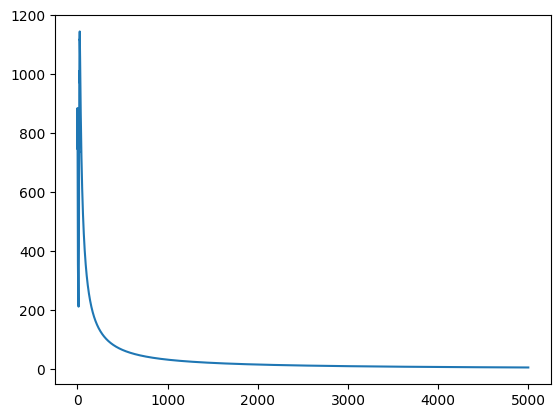

In [ ]:
plt.plot(Regret_J_n)

## $\psi$ = [0.5]*int(T/2) + [1.5]*int(T/2)

In [ ]:
# Precompute constants
sqrt_alphas = np.sqrt(alphas)
freq_terms = q**2 + (2*np.pi)**2 * np.ceil(np.arange(2*N+1)/2)**2
alpha_freq = alphas * freq_terms

# Initialize arrays
w = np.zeros((T, 2*N+1))
w_wave = np.zeros((T, 2*N+1))
w[0] = np.random.random(2*N+1)
w_wave[0] = np.random.random(2*N+1)

# Tracking variables
Regret_J_n, Regret_J_n_sqrt = [], []
Dif_J_n = []
grads = []
psi = [0.5]*int(T/2) + [1.5]*int(T/2)

# Learning rate setup
eta = np.zeros(T)
eta[0] = D/np.sqrt(10*D**2*L**2 + 4*G**2)
gradient_w = np.zeros((T, 2*N+1))
dif_grads_norm = []

t = symbols('t')  # Time symbol

for i in range(T-1):
    # System dynamics
    h_sp = 10*pi**2*cos(2*psi[i]*pi*t)
    h = lambdify(t, h_sp, 'numpy')
    x_sp = solve_euler(h_sp, q)
    x = lambdify(t, x_sp, 'numpy')

    # Fourier coefficients
    a0, an, bn = pop_fourier_coefs(x)
    h_a0, h_an, h_bn = pop_fourier_coefs(h)
    x_hat = join_arrs(a0, an, bn)
    h_hat = join_arrs(h_a0, h_an, h_bn)

    # Gradient and objective
    gradient_w[i+1] = alpha_freq * w[i] - sqrt_alphas * h_hat
    J_n_current = 0.5*np.sum(alpha_freq * w[i]**2) - np.sum(sqrt_alphas * h_hat * w[i])

    # Update learning rate
    grad_diff = gradient_w[i+1] - gradient_w[i]
    dif_grads_norm.append(np.dot(grad_diff, grad_diff))
    eta[i+1] = D/np.sqrt(10*D**2*L**2 + 4*G**2 + np.sum(dif_grads_norm))

    # Weight updates
    w_wave[i+1] = w_wave[i] - eta[i]*gradient_w[i]
    w[i+1] = w_wave[i+1] - eta[i+1]*gradient_w[i]

    # Regret calculation
    current_diff = J_n_current - (0.5*np.sum(alpha_freq * (x_hat/sqrt_alphas)**2) - np.sum(sqrt_alphas * h_hat * (x_hat/sqrt_alphas)))
    Dif_J_n.append(current_diff)
    n = len(Dif_J_n)
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(n))
    Regret_J_n.append(np.sum(Dif_J_n)/n)

In [ ]:
np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))

np.float64(7.57834354558895e-05)

In [ ]:
Regret_J_n[-1]

np.float64(6.747793108333894)

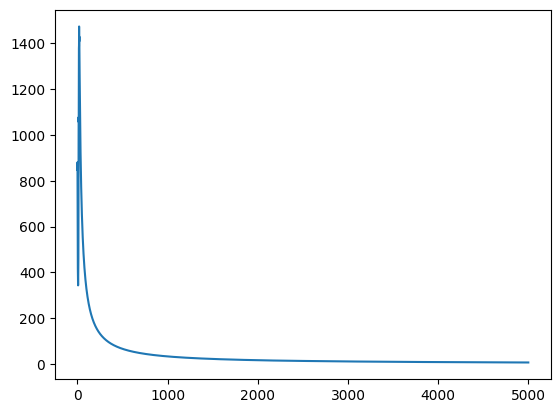

In [ ]:
plt.plot(Regret_J_n)

## $\psi$ = np.linspace(2, 3, T) + np.random.normal(0, 0.03, T)

In [ ]:
# Precompute constants
sqrt_alphas = np.sqrt(alphas)
freq_terms = q**2 + (2*np.pi)**2 * np.ceil(np.arange(2*N+1)/2)**2
alpha_freq = alphas * freq_terms

# Initialize arrays
w = np.zeros((T, 2*N+1))
w_wave = np.zeros((T, 2*N+1))
w[0] = np.random.random(2*N+1)
w_wave[0] = np.random.random(2*N+1)

# Tracking variables
Regret_J_n, Regret_J_n_sqrt = [], []
Dif_J_n = []
grads = []
psi = np.linspace(2, 3, T) + np.random.normal(0, 0.03, T)

# Learning rate setup
eta = np.zeros(T)
eta[0] = D/np.sqrt(10*D**2*L**2 + 4*G**2)
gradient_w = np.zeros((T, 2*N+1))
dif_grads_norm = []

t = symbols('t')  # Time symbol

for i in range(T-1):
    # System dynamics
    h_sp = 10*pi**2*cos(2*psi[i]*pi*t)
    h = lambdify(t, h_sp, 'numpy')
    x_sp = solve_euler(h_sp, q)
    x = lambdify(t, x_sp, 'numpy')

    # Fourier coefficients
    a0, an, bn = pop_fourier_coefs(x)
    h_a0, h_an, h_bn = pop_fourier_coefs(h)
    x_hat = join_arrs(a0, an, bn)
    h_hat = join_arrs(h_a0, h_an, h_bn)

    # Gradient and objective
    gradient_w[i+1] = alpha_freq * w[i] - sqrt_alphas * h_hat
    J_n_current = 0.5*np.sum(alpha_freq * w[i]**2) - np.sum(sqrt_alphas * h_hat * w[i])

    # Update learning rate
    grad_diff = gradient_w[i+1] - gradient_w[i]
    dif_grads_norm.append(np.dot(grad_diff, grad_diff))
    eta[i+1] = D/np.sqrt(10*D**2*L**2 + 4*G**2 + np.sum(dif_grads_norm))

    # Weight updates
    w_wave[i+1] = w_wave[i] - eta[i]*gradient_w[i]
    w[i+1] = w_wave[i+1] - eta[i+1]*gradient_w[i]

    # Regret calculation
    current_diff = J_n_current - (0.5*np.sum(alpha_freq * (x_hat/sqrt_alphas)**2) - np.sum(sqrt_alphas * h_hat * (x_hat/sqrt_alphas)))
    Dif_J_n.append(current_diff)
    n = len(Dif_J_n)
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(n))
    Regret_J_n.append(np.sum(Dif_J_n)/n)

In [ ]:
np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))

np.float64(0.05003349128361023)

In [ ]:
Regret_J_n[-1]

np.float64(7.267317495323603)

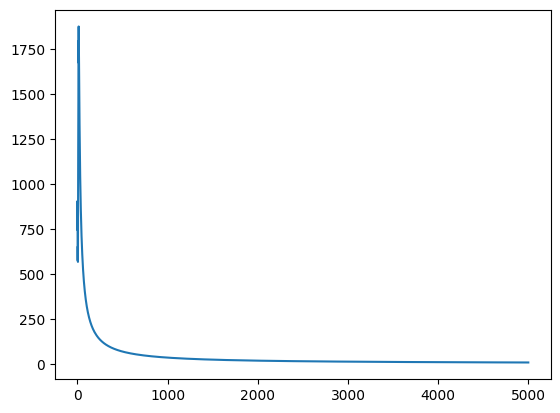

In [ ]:
plt.plot(Regret_J_n)

## Strong convexity (take another $\eta$)
eta = [2/(10*(i+1)) for i in range(T)]

## $\psi$ = 1.5

In [ ]:
# Initialize arrays
w = np.zeros((T, 2*N+1))
w_wave = np.zeros((T, 2*N+1))
w[0] = np.random.random(2*N+1)
w_wave[0] = np.random.random(2*N+1)

# System setup
t = symbols('t')
h_sp = 10*pi**2*cos(2*1.5*pi*t)
h = lambdify(t, h_sp, 'numpy')

# Solve system and get Fourier coefficients
x_sp = solve_euler(h_sp, q)
x = lambdify(t, x_sp, 'numpy')
a0, an, bn = pop_fourier_coefs(x)
h_a0, h_an, h_bn = pop_fourier_coefs(h)
x_hat = join_arrs(a0, an, bn)
h_hat = join_arrs(h_a0, h_an, h_bn)

# Precompute terms
sqrt_alphas = np.sqrt(alphas)
freq_terms = q**2 + (2*np.pi)**2 * ((np.arange(2*N+1) // 2)**2)
alpha_freq = alphas * freq_terms

# Define functions
gradient = lambda w: alpha_freq * w - sqrt_alphas * h_hat
J_n = lambda w: 0.5*np.sum(alpha_freq * w**2) - np.sum(sqrt_alphas * h_hat * w)

# Initialize trackers
gradient_history = np.zeros((T, 2*N+1))
dif_grads_norm = []
J_opt = J_n(x_hat / sqrt_alphas)
Regret_J_n, Regret_J_n_sqrt = [], []
Dif_J_n = []

# Learning rates
eta = [2/(10*(i+1)) for i in range(T)]

# Main loop
for i in range(T-1):
    gradient_history[i+1] = gradient(w[i])

    grad_diff = gradient_history[i+1] - gradient_history[i]
    dif_grads_norm.append(np.dot(grad_diff, grad_diff))

    w_wave[i+1] = w_wave[i] - eta[i] * gradient_history[i]
    w[i+1] = w_wave[i+1] - eta[i+1] * gradient_history[i]

    current_diff = J_n(w[i]) - J_opt
    Dif_J_n.append(current_diff)
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(len(Dif_J_n)))
    Regret_J_n.append(np.sum(Dif_J_n)/len(Dif_J_n))

In [ ]:
np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))

np.float64(7.578343201686266e-05)

In [ ]:
Regret_J_n[-1]

np.float64(2876893808.655221)

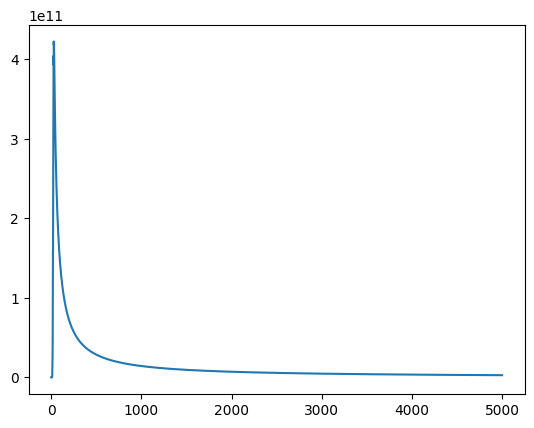

In [ ]:
plt.plot(Regret_J_n)

## $\psi$ = np.random.normal(0, 0.03, T)

In [ ]:
# Precompute constants and initialize arrays
sqrt_alphas = np.sqrt(alphas)
freq_terms = q**2 + (2*np.pi)**2 * np.ceil(np.arange(2*N+1)/2)**2
alpha_freq = alphas * freq_terms

w = np.zeros((T, 2*N+1))
w_wave = np.zeros((T, 2*N+1))
w[0], w_wave[0] = np.random.random(2*N+1), np.random.random(2*N+1)

# Tracking variables
Regret_J_n, Regret_J_n_sqrt, Dif_J_n = [], [], []
gradient_w = np.zeros((T, 2*N+1))
dif_grads_norm = []
psi = np.random.normal(0, 0.03, T)
t = symbols('t')
eta = [2/(10*(i+1)) for i in range(T)]

for i in range(T-1):
    # System dynamics
    h = lambdify(t, 10*pi**2*cos(2*psi[i]*pi*t), 'numpy')
    x = lambdify(t, solve_euler(h_sp, q), 'numpy')

    # Fourier coefficients
    x_hat = join_arrs(*pop_fourier_coefs(x))
    h_hat = join_arrs(*pop_fourier_coefs(h))

    # Gradient and weight updates
    gradient = lambda w: alpha_freq * w - sqrt_alphas * h_hat
    gradient_w[i+1] = gradient(w[i])

    grad_diff = gradient_w[i+1] - gradient_w[i]
    dif_grads_norm.append(np.dot(grad_diff, grad_diff))

    w_wave[i+1] = w_wave[i] - eta[i]*gradient_w[i]
    w[i+1] = w_wave[i+1] - eta[i+1]*gradient_w[i]

    # Regret calculation
    J_n = lambda w: 0.5*np.sum(alpha_freq * w**2) - np.sum(sqrt_alphas * h_hat * w)
    current_diff = J_n(w[i]) - J_n(x_hat/sqrt_alphas)
    Dif_J_n.append(current_diff)

    n = len(Dif_J_n)
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(n))
    Regret_J_n.append(np.sum(Dif_J_n)/n)

In [ ]:
np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))

np.float64(5.185449390410213e-05)

In [ ]:
Regret_J_n[-1]

np.float64(3.861850874312884e+42)

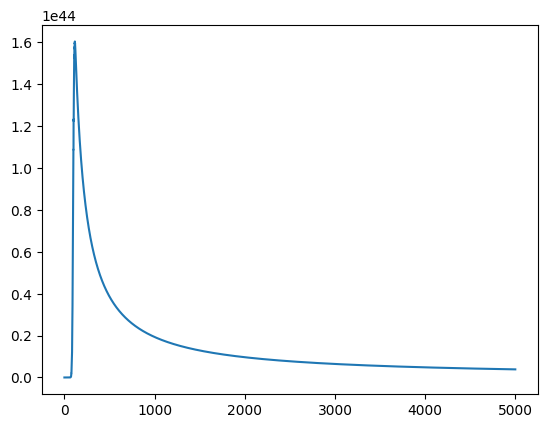

In [ ]:
plt.plot(Regret_J_n)

## $\psi$ = np.linspace(2, 3, T)

In [ ]:
# Precompute constants and initialize arrays
sqrt_alphas = np.sqrt(alphas)
freq_terms = q**2 + (2*np.pi)**2 * np.ceil(np.arange(2*N+1)/2)**2
alpha_freq = alphas * freq_terms

w = np.zeros((T, 2*N+1))
w_wave = np.zeros((T, 2*N+1))
w[0], w_wave[0] = np.random.random(2*N+1), np.random.random(2*N+1)

# Tracking variables
Regret_J_n, Regret_J_n_sqrt, Dif_J_n = [], [], []
gradient_w = np.zeros((T, 2*N+1))
dif_grads_norm = []
psi = np.linspace(2, 3, T)
t = symbols('t')
eta = [2/(10*(i+1)) for i in range(T)]

for i in range(T-1):
    # System dynamics
    h = lambdify(t, 10*pi**2*cos(2*psi[i]*pi*t), 'numpy')
    x = lambdify(t, solve_euler(h_sp, q), 'numpy')

    # Fourier coefficients
    x_hat = join_arrs(*pop_fourier_coefs(x))
    h_hat = join_arrs(*pop_fourier_coefs(h))

    # Gradient and weight updates
    gradient = lambda w: alpha_freq * w - sqrt_alphas * h_hat
    gradient_w[i+1] = gradient(w[i])

    grad_diff = gradient_w[i+1] - gradient_w[i]
    dif_grads_norm.append(np.dot(grad_diff, grad_diff))

    w_wave[i+1] = w_wave[i] - eta[i]*gradient_w[i]
    w[i+1] = w_wave[i+1] - eta[i+1]*gradient_w[i]

    # Regret calculation
    J_n = lambda w: 0.5*np.sum(alpha_freq * w**2) - np.sum(sqrt_alphas * h_hat * w)
    current_diff = J_n(w[i]) - J_n(x_hat/sqrt_alphas)
    Dif_J_n.append(current_diff)

    n = len(Dif_J_n)
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(n))
    Regret_J_n.append(np.sum(Dif_J_n)/n)

In [ ]:
np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))

np.float64(1.8680347262380286)

In [ ]:
Regret_J_n[-1]

np.float64(8.937325727188914e+42)

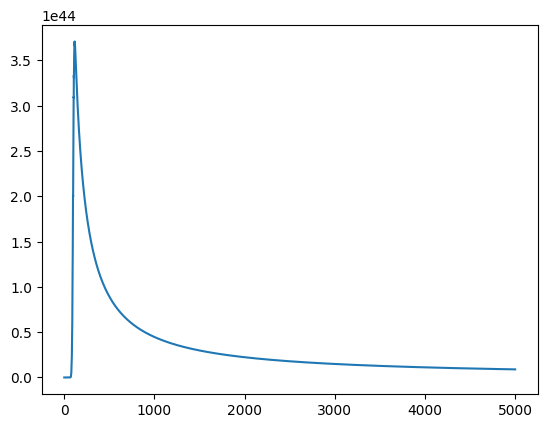

In [ ]:
plt.plot(Regret_J_n)

## $\psi$ = [0.5]*int(T/2) + [1.5]*int(T/2)

In [ ]:
# Precompute constants and initialize arrays
sqrt_alphas = np.sqrt(alphas)
freq_terms = q**2 + (2*np.pi)**2 * np.ceil(np.arange(2*N+1)/2)**2
alpha_freq = alphas * freq_terms

w = np.zeros((T, 2*N+1))
w_wave = np.zeros((T, 2*N+1))
w[0], w_wave[0] = np.random.random(2*N+1), np.random.random(2*N+1)

# Tracking variables
Regret_J_n, Regret_J_n_sqrt, Dif_J_n = [], [], []
gradient_w = np.zeros((T, 2*N+1))
dif_grads_norm = []
psi = [0.5]*int(T/2) + [1.5]*int(T/2)
t = symbols('t')
eta = [2/(10*(i+1)) for i in range(T)]

for i in range(T-1):
    # System dynamics
    h = lambdify(t, 10*pi**2*cos(2*psi[i]*pi*t), 'numpy')
    x = lambdify(t, solve_euler(h_sp, q), 'numpy')

    # Fourier coefficients
    x_hat = join_arrs(*pop_fourier_coefs(x))
    h_hat = join_arrs(*pop_fourier_coefs(h))

    # Gradient and weight updates
    gradient = lambda w: alpha_freq * w - sqrt_alphas * h_hat
    gradient_w[i+1] = gradient(w[i])

    grad_diff = gradient_w[i+1] - gradient_w[i]
    dif_grads_norm.append(np.dot(grad_diff, grad_diff))

    w_wave[i+1] = w_wave[i] - eta[i]*gradient_w[i]
    w[i+1] = w_wave[i+1] - eta[i+1]*gradient_w[i]

    # Regret calculation
    J_n = lambda w: 0.5*np.sum(alpha_freq * w**2) - np.sum(sqrt_alphas * h_hat * w)
    current_diff = J_n(w[i]) - J_n(x_hat/sqrt_alphas)
    Dif_J_n.append(current_diff)

    n = len(Dif_J_n)
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(n))
    Regret_J_n.append(np.sum(Dif_J_n)/n)

In [ ]:
np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))

np.float64(7.576383271867826e-05)

In [ ]:
Regret_J_n[-1]

np.float64(9.598695661785133e+43)

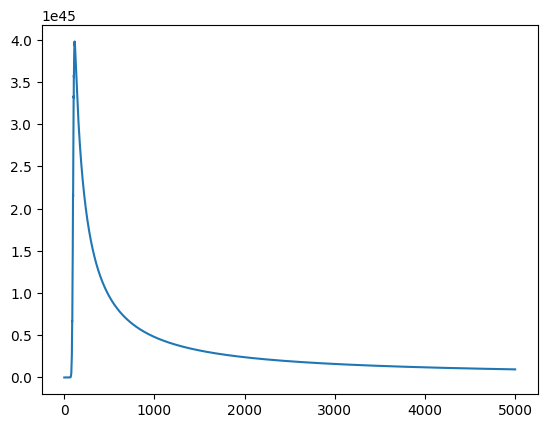

In [ ]:
plt.plot(Regret_J_n)

## $\psi$ = np.linspace(2, 3, T) + np.random.normal(0, 0.03, T)

In [7]:
# Precompute constants and initialize arrays
sqrt_alphas = np.sqrt(alphas)
freq_terms = q**2 + (2*np.pi)**2 * np.ceil(np.arange(2*N+1)/2)**2
alpha_freq = alphas * freq_terms

w = np.zeros((T, 2*N+1))
w_wave = np.zeros((T, 2*N+1))
w[0], w_wave[0] = np.random.random(2*N+1), np.random.random(2*N+1)

# Tracking variables
Regret_J_n, Regret_J_n_sqrt, Dif_J_n = [], [], []
gradient_w = np.zeros((T, 2*N+1))
dif_grads_norm = []
psi = np.linspace(2, 3, T) + np.random.normal(0, 0.03, T)
t = symbols('t')
eta = [2/(10*(i+1)) for i in range(T)]

for i in range(T-1):
    # System dynamics
    h = lambdify(t, 10*pi**2*cos(2*psi[i]*pi*t), 'numpy')
    x = lambdify(t, solve_euler(h_sp, q), 'numpy')

    # Fourier coefficients
    x_hat = join_arrs(*pop_fourier_coefs(x))
    h_hat = join_arrs(*pop_fourier_coefs(h))

    # Gradient and weight updates
    gradient = lambda w: alpha_freq * w - sqrt_alphas * h_hat
    gradient_w[i+1] = gradient(w[i])

    grad_diff = gradient_w[i+1] - gradient_w[i]
    dif_grads_norm.append(np.dot(grad_diff, grad_diff))

    w_wave[i+1] = w_wave[i] - eta[i]*gradient_w[i]
    w[i+1] = w_wave[i+1] - eta[i+1]*gradient_w[i]

    # Regret calculation
    J_n = lambda w: 0.5*np.sum(alpha_freq * w**2) - np.sum(sqrt_alphas * h_hat * w)
    current_diff = J_n(w[i]) - J_n(x_hat/sqrt_alphas)
    Dif_J_n.append(current_diff)

    n = len(Dif_J_n)
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(n))
    Regret_J_n.append(np.sum(Dif_J_n)/n)

In [8]:
np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))

np.float64(0.05863415684162909)

In [9]:
Regret_J_n[-1]

np.float64(1.3144349039204185e+44)

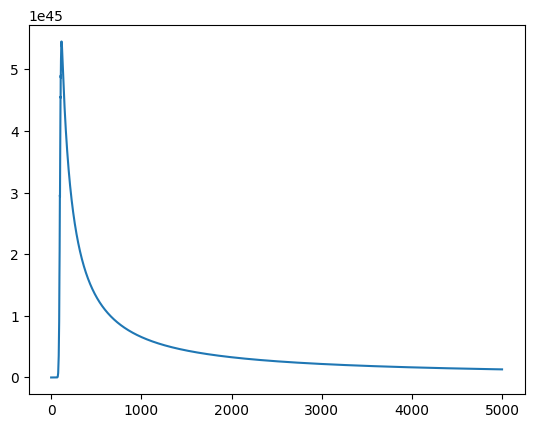

In [10]:
plt.plot(Regret_J_n)